In [2]:
import pandas as pd
from sodapy import Socrata
import os
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
import datetime
from geopandas import GeoDataFrame as gdf
from shapely.geometry import Point
from shapely.geometry import Polygon
import psycopg2
%matplotlib inline

/Users/alenastern/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# Get Graffiti 311 Data from Chicago Data Portal API
graffiti_id = "cdmx-wzbz"
client = Socrata("data.cityofchicago.org", 'BOetEt3G4uynCIa1XQuFyRS8X')

g_results = client.get(graffiti_id, where="creation_date between '2017-01-01T00:00:00' and '2017-12-31T00:00:00'", limit = 2000000)
g_df = pd.DataFrame.from_records(g_results)

In [4]:
# Get Vacant and Abandoned Buildings 311 Data from Chicago Data Portal API
buildings_id = "yama-9had"
b_results = client.get(buildings_id, where="date_service_request_was_received between '2017-01-01T00:00:00' and '2017-12-31T00:00:00'", limit = 2000000)
b_df = pd.DataFrame.from_records(b_results)
b_df["street_address"] = b_df.address_street_number+" "+b_df.address_street_direction+" "+b_df.address_street_name+" "+b_df.address_street_suffix
b_df.rename(index=str, columns={"date_service_request_was_received": "creation_date", "service_request_type": "type_of_service_request"}, inplace = True)

In [5]:
# Get Alley Lights Out 311 Data from Chicago Data Portal API
alleys_id = "j9pw-ad5p"
a_results = client.get(alleys_id, where="creation_date between '2017-01-01T00:00:00' and '2017-12-31T00:00:00'", limit = 2000000)
a_df = pd.DataFrame.from_records(a_results)

In [6]:
# Get community areas data from Chicago Data Portal API
com_area_id = "igwz-8jzy"
ca_results = client.get(com_area_id)
ca_df = pd.DataFrame.from_records(ca_results)

In [7]:
ca_names = ca_df[["area_num_1", "community"]].copy()
ca_names.rename(index = str, columns = {"area_num_1": "community_area"}, inplace = True)

In [8]:
# Concatenate the 311 calls dataframes into one, merge in community area name, calculate response time variable
all_call = pd.concat([g_df, b_df, a_df], axis = 0, ignore_index = True)
all_call = pd.merge(all_call, ca_names, on = 'community_area', how = 'left')
all_call['response_time'] = (pd.to_datetime(all_call['completion_date']) - pd.to_datetime(all_call['creation_date'])).dt.days

In [9]:
# Clean where_is_the_graffiti_located_ column
mask = all_call.where_is_the_graffiti_located_ == "Express Way Job - DSS will NOT remove"
column_name = 'where_is_the_graffiti_located_'
all_call.loc[mask, column_name] = "Express Way Job"

In [10]:
# Count number of service requests by type
all_call.groupby("type_of_service_request").size().reset_index(name="count")

,type_of_service_request,count
0,Alley Light Out,27895
1,Graffiti Removal,112779
2,Vacant/Abandoned Building,3666


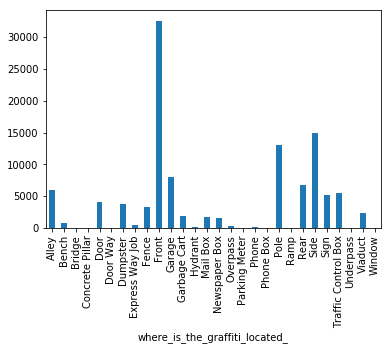

In [22]:
# Count number of Grafitti sub-type 
p1 = all_call.groupby(["where_is_the_graffiti_located_"]).size()
p1.plot.bar()

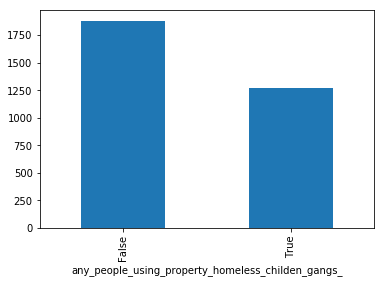

In [11]:
# Count number of abandoned building subtype
p1 = all_call.groupby(["any_people_using_property_homeless_childen_gangs_"]).size()
p1.plot.bar()

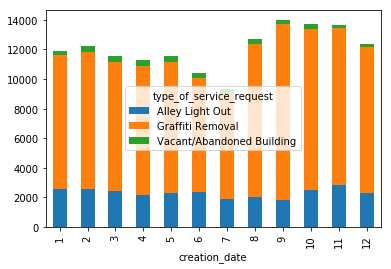

In [12]:
# Count number of service requests per month
pt = all_call.groupby([pd.to_datetime(all_call.creation_date).dt.month, all_call.type_of_service_request]).size().reset_index(name="count")
piv = pt.pivot(index='creation_date', columns='type_of_service_request', values='count')
piv.plot.bar(stacked= True)

In [13]:
# Count number of service requests by community area
grouped = all_call.groupby("community").size().reset_index(name="count")
grouped.sort_values(by = "count", ascending=False)

,community,count
75,WEST TOWN,10272
40,LOGAN SQUARE,8162
64,SOUTH LAWNDALE,6675
42,LOWER WEST SIDE,6216
11,BRIGHTON PARK,5784
7,AVONDALE,4751
37,LAKE VIEW,4730
43,MCKINLEY PARK,4693
26,GAGE PARK,3825
8,BELMONT CRAGIN,3744


In [32]:
grouped = all_call.groupby("community")['response_time'].mean().reset_index(name="average_response_time")
grouped.sort_values(by = "average_response_time", ascending=False)

,community,average_response_time
55,OAKLAND,43.829787
59,RIVERDALE,37.230769
45,MORGAN PARK,35.706320
73,WEST PULLMAN,32.679831
9,BEVERLY,31.305000
29,GREATER GRAND CROSSING,30.977099
14,CHATHAM,30.262887
6,AVALON PARK,30.225490
76,WOODLAWN,29.675373
65,SOUTH SHORE,28.497592


In [14]:
grouped = all_call.groupby("type_of_service_request")['response_time'].mean().reset_index(name="average_response_time")
grouped.sort_values(by= "average_response_time", ascending=False)

,type_of_service_request,average_response_time
0,Alley Light Out,33.705919
1,Graffiti Removal,0.676226
2,Vacant/Abandoned Building,NaN


**Question 1 Response**

The findings above illuminate several interesting trends about responses to 311 requests in the city of Chicago. I highlight five interesting things I learned performing this analysis below:
1. The city of Chicago receives vastly more graffiti removal requests than alley lights out requests or vacant building requests. This result likely indicates the higher incidence of graffiti than vacant buildings or alley lights out. 
2. There are significant disparities in the average response time to 311 calls in the city. The areas that experience the fastest response times tend to be of key commercial importance (such as the Loop or O'Hare Airport) or higher-income areas. The areas with the slowest response times tend to be lower-income areas.
3. There is a significant disconnect between the community areas that place the most 311 requests and the response time to 311 requests in those areas. This may reflect that citizens living in community areas with slow response times have become disenfranchised and do not expect the city to respond to their needs. 
4. The number of 311 requests placed per month is highest in the months of September, October, and November, largely driven by increases in the number of graffiti removal calls in those months. This was a surprising finding as I would have expected the number of graffiti removal requests to be highest in the summer when school is not in session.
5. Over 40% of buildings reported as vacant are being used by people at the time of the report. 

In [15]:
# Query ACS Data
acs_results = requests.get('https://api.census.gov/data/2016/acs/acs5?get=NAME,B01003_001E,B02001_002E,B02001_003E,B15003_022E,B19001_001E&for=block%20group:*&in=state:17%20county:031&key=91aa6a44edb890abeea862f2d9befb5d520a5cc4')
data = acs_results.text
acs_df = pd.read_json(data)

In [16]:
variables = {'B01003_001E': "total_pop", 'B02001_002E': "total_white", 'B02001_003E': "total_black", 'B15003_022E': "bachelors_degree", 'B19001_001E': "total_income"}
acs_df.columns = acs_df.iloc[0]
acs_df.drop([0], inplace = True)
acs_df.rename(columns = variables, inplace=True)

In [17]:
acs_df['pct_black'] = pd.to_numeric(acs_df['total_black'])/ pd.to_numeric(acs_df['total_pop'])
acs_df['pct_white'] = pd.to_numeric(acs_df['total_white'])/ pd.to_numeric(acs_df['total_pop'])
acs_df['pct_bachelors'] = pd.to_numeric(acs_df['bachelors_degree'])/ pd.to_numeric(acs_df['total_pop'])
acs_df['GEOID']= acs_df["state"] + acs_df["county"] + acs_df["tract"] + acs_df["block group"]

In [48]:
all_call.head()

,address_street_direction,address_street_name,address_street_number,address_street_suffix,any_people_using_property_homeless_childen_gangs_,community_area,completion_date,creation_date,if_the_building_is_open_where_is_the_entry_point_,is_building_open_or_boarded_,...,street_address,type_of_service_request,ward,what_type_of_surface_is_the_graffiti_on_,where_is_the_graffiti_located_,x_coordinate,y_coordinate,zip_code,community,response_time
0,NaN,NaN,NaN,NaN,NaN,66,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,7125 S MAPLEWOOD AVE,Graffiti Removal,18,Metal - Painted,Door,1160606.3195708,1857319.79946719,60629,CHICAGO LAWN,0.0
1,NaN,NaN,NaN,NaN,NaN,4,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,4409 N ARTESIAN AVE,Graffiti Removal,47,Wood - Painted,Front,1159245.97991312,1929206.66469635,60625,LINCOLN SQUARE,2.0
2,NaN,NaN,NaN,NaN,NaN,28,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,1557 W 13TH ST,Graffiti Removal,28,Metal - Painted,Dumpster,1166057.81087376,1894135.42000548,60608,NEAR WEST SIDE,0.0
3,NaN,NaN,NaN,NaN,NaN,21,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,3510 N KEDZIE AVE,Graffiti Removal,35,Metal - Painted,Dumpster,1154428.449525,1923227.687975,60618,AVONDALE,0.0
4,NaN,NaN,NaN,NaN,NaN,4,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,2301 W SUNNYSIDE AVE,Graffiti Removal,47,Other/Unknown Surface,Garbage Cart,1160210.11016623,1929833.54508122,60625,LINCOLN SQUARE,2.0


In [18]:
# read in census 2010 shapefile downloaded manually from census website
fp = "/Users/alenastern/Documents/Spring2018/Machine_Learning/tl_2017_17_bg/tl_2017_17_bg.shp"
census_shp = gpd.read_file(fp)

In [65]:
census_shp.crs

{'init': 'epsg:4269'}

In [19]:
#change to be latitude and longitude and try again!!!
geometry = [Point(xy) for xy in zip(pd.to_numeric(all_call.x_coordinate), pd.to_numeric(all_call.y_coordinate))]
all_call2 = all_call.drop(['x_coordinate', 'y_coordinate'], axis=1)
crs = {'init': 'epsg:4326'}
gdf_calls = gdf(all_call2, crs=crs, geometry=geometry)
gdf_calls = gdf_calls[gdf_calls['geometry'].is_valid]

In [20]:
shp_geom = census_shp[["GEOID", "geometry"]].copy()
acs_df = pd.merge(acs_df, shp_geom, on = 'GEOID', how = 'left')
acs_df.head()

,NAME,total_pop,total_white,total_black,bachelors_degree,total_income,state,county,tract,block group,pct_black,pct_white,pct_bachelors,GEOID,geometry
0,"Block Group 1, Census Tract 101, Cook County, ...",639,288,232,75,312,17,031,010100,1,0.363067,0.450704,0.117371,170310101001,"POLYGON ((-87.67071799999999 42.021376, -87.67..."
1,"Block Group 2, Census Tract 101, Cook County, ...",1768,676,1009,128,833,17,031,010100,2,0.570701,0.382353,0.072398,170310101002,"POLYGON ((-87.677199 42.022942, -87.676277 42...."
2,"Block Group 3, Census Tract 101, Cook County, ...",1981,1252,475,414,1061,17,031,010100,3,0.239778,0.632004,0.208985,170310101003,"POLYGON ((-87.672646 42.022996, -87.6718849999..."
3,"Block Group 1, Census Tract 102.01, Cook Count...",1417,588,656,242,619,17,031,010201,1,0.462950,0.414961,0.170783,170310102011,"POLYGON ((-87.684083 42.015151, -87.683869 42...."
4,"Block Group 2, Census Tract 102.01, Cook Count...",4641,1962,2319,554,1673,17,031,010201,2,0.499677,0.422754,0.119371,170310102012,"POLYGON ((-87.684653 42.019485, -87.6843169999..."


In [130]:
geometry = [Polygon(x) for x in acs_df.geometry]
acs_df2 = acs_df.drop(['geometry'], axis=1)
crs ={'init': 'epsg:4269'}
#crs = ('+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +units=m no_defs')
gdf_acs = gdf(acs_df2, crs=crs, geometry=geometry)
#crs_target = ('+init=EPSG:4674')


In [21]:
gdf_calls.head()


,address_street_direction,address_street_name,address_street_number,address_street_suffix,any_people_using_property_homeless_childen_gangs_,community_area,completion_date,creation_date,if_the_building_is_open_where_is_the_entry_point_,is_building_open_or_boarded_,...,status,street_address,type_of_service_request,ward,what_type_of_surface_is_the_graffiti_on_,where_is_the_graffiti_located_,zip_code,community,response_time,geometry
0,NaN,NaN,NaN,NaN,NaN,66,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,7125 S MAPLEWOOD AVE,Graffiti Removal,18,Metal - Painted,Door,60629,CHICAGO LAWN,0.0,POINT (1160606.3195708 1857319.79946719)
1,NaN,NaN,NaN,NaN,NaN,4,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,Completed,4409 N ARTESIAN AVE,Graffiti Removal,47,Wood - Painted,Front,60625,LINCOLN SQUARE,2.0,POINT (1159245.97991312 1929206.66469635)
2,NaN,NaN,NaN,NaN,NaN,28,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,1557 W 13TH ST,Graffiti Removal,28,Metal - Painted,Dumpster,60608,NEAR WEST SIDE,0.0,POINT (1166057.81087376 1894135.42000548)
3,NaN,NaN,NaN,NaN,NaN,21,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,3510 N KEDZIE AVE,Graffiti Removal,35,Metal - Painted,Dumpster,60618,AVONDALE,0.0,POINT (1154428.449525 1923227.687975)
4,NaN,NaN,NaN,NaN,NaN,4,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,Completed - Dup,2301 W SUNNYSIDE AVE,Graffiti Removal,47,Other/Unknown Surface,Garbage Cart,60625,LINCOLN SQUARE,2.0,POINT (1160210.11016623 1929833.54508122)


In [27]:
#gdf_acs['geometry'] = gdf_acs['geometry'].to_crs(epsg=4326)
#gdf_acs = gdf_acs.to_crs({'init': 'epsg=4326'})
#gdf_acs = gdf_acs.to_crs(epsg =4326)
crs_target = ('+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +units=m +no_defs')
gdf_calls['geometry']= gdf_calls['geometry'].to_crs(crs_target)

RuntimeError: b'latitude or longitude exceeded limits'

In [138]:
all_call_acs = gpd.sjoin(gdf_calls, gdf_acs, how="left")

In [26]:
gdf_calls[:10]

,address_street_direction,address_street_name,address_street_number,address_street_suffix,any_people_using_property_homeless_childen_gangs_,community_area,completion_date,creation_date,if_the_building_is_open_where_is_the_entry_point_,is_building_open_or_boarded_,...,status,street_address,type_of_service_request,ward,what_type_of_surface_is_the_graffiti_on_,where_is_the_graffiti_located_,zip_code,community,response_time,geometry
0,NaN,NaN,NaN,NaN,NaN,66,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,7125 S MAPLEWOOD AVE,Graffiti Removal,18,Metal - Painted,Door,60629,CHICAGO LAWN,0.0,POINT (1160606.3195708 1857319.79946719)
1,NaN,NaN,NaN,NaN,NaN,4,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,Completed,4409 N ARTESIAN AVE,Graffiti Removal,47,Wood - Painted,Front,60625,LINCOLN SQUARE,2.0,POINT (1159245.97991312 1929206.66469635)
2,NaN,NaN,NaN,NaN,NaN,28,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,1557 W 13TH ST,Graffiti Removal,28,Metal - Painted,Dumpster,60608,NEAR WEST SIDE,0.0,POINT (1166057.81087376 1894135.42000548)
3,NaN,NaN,NaN,NaN,NaN,21,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,3510 N KEDZIE AVE,Graffiti Removal,35,Metal - Painted,Dumpster,60618,AVONDALE,0.0,POINT (1154428.449525 1923227.687975)
4,NaN,NaN,NaN,NaN,NaN,4,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,Completed - Dup,2301 W SUNNYSIDE AVE,Graffiti Removal,47,Other/Unknown Surface,Garbage Cart,60625,LINCOLN SQUARE,2.0,POINT (1160210.11016623 1929833.54508122)
5,NaN,NaN,NaN,NaN,NaN,20,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,Completed,2520 N KILBOURN AVE,Graffiti Removal,31,Aluminum Siding,Alley,60639,HERMOSA,2.0,POINT (1145958.36982059 1916551.22010653)
6,NaN,NaN,NaN,NaN,NaN,22,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,Completed,2306 W MOFFAT ST,Graffiti Removal,32,Metal - Painted,Door,60647,LOGAN SQUARE,2.0,POINT (1160680.44779372 1912316.97737679)
7,NaN,NaN,NaN,NaN,NaN,56,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,Completed,6841 W 57TH ST,Graffiti Removal,13,Other/Unknown Surface,Alley,60638,GARFIELD RIDGE,2.0,POINT (1131653.63100375 1865982.0165813)
8,NaN,NaN,NaN,NaN,NaN,56,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,5103 S CICERO AVE,Graffiti Removal,14,Brick - Unpainted,Side,60632,GARFIELD RIDGE,0.0,POINT (1145222.56478353 1870370.20420231)
9,NaN,NaN,NaN,NaN,NaN,59,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,3637 S DAMEN AVE,Graffiti Removal,12,Metal - Painted,Garage,60609,MCKINLEY PARK,0.0,POINT (1163616.43658405 1880558.68722658)


In [191]:
conn = psycopg2.connect(database='capp30254', user='alenastern', password='', host='localhost', port='5432')
c = conn.cursor()

In [164]:
shp_str = "shp2pgsql -s 102003:4326 /Users/alenastern/Documents/Spring2018/Machine_Learning/tl_2017_17_bg/tl_2017_17_bg.shp public.census_2017_bgp | psql -d capp30254"
os.system(shp_str)

0

In [165]:
gdf_calls.head()

,address_street_direction,address_street_name,address_street_number,address_street_suffix,any_people_using_property_homeless_childen_gangs_,community_area,completion_date,creation_date,if_the_building_is_open_where_is_the_entry_point_,is_building_open_or_boarded_,...,status,street_address,type_of_service_request,ward,what_type_of_surface_is_the_graffiti_on_,where_is_the_graffiti_located_,zip_code,community,response_time,geometry
index_left,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,66,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,7125 S MAPLEWOOD AVE,Graffiti Removal,18,Metal - Painted,Door,60629,CHICAGO LAWN,0.0,POINT (1160606.3195708 1857319.79946719)
1,NaN,NaN,NaN,NaN,NaN,4,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,Completed,4409 N ARTESIAN AVE,Graffiti Removal,47,Wood - Painted,Front,60625,LINCOLN SQUARE,2.0,POINT (1159245.97991312 1929206.66469635)
2,NaN,NaN,NaN,NaN,NaN,28,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,1557 W 13TH ST,Graffiti Removal,28,Metal - Painted,Dumpster,60608,NEAR WEST SIDE,0.0,POINT (1166057.81087376 1894135.42000548)
3,NaN,NaN,NaN,NaN,NaN,21,2017-08-07T00:00:00.000,2017-08-07T00:00:00.000,NaN,NaN,...,Completed,3510 N KEDZIE AVE,Graffiti Removal,35,Metal - Painted,Dumpster,60618,AVONDALE,0.0,POINT (1154428.449525 1923227.687975)
4,NaN,NaN,NaN,NaN,NaN,4,2017-08-07T00:00:00.000,2017-08-05T00:00:00.000,NaN,NaN,...,Completed - Dup,2301 W SUNNYSIDE AVE,Graffiti Removal,47,Other/Unknown Surface,Garbage Cart,60625,LINCOLN SQUARE,2.0,POINT (1160210.11016623 1929833.54508122)


In [194]:
gdf_calls_pgsql = gdf_calls[['completion_date', 'creation_date', 'type_of_service_request', 'community','response_time', 'geometry']]
c.execute("CREATE TABLE chi_calls (id int, completion_date date, creation_date date, type_of_service_request varchar(50), community varchar(50), response_time float8, geometry geometry);")

In [193]:
gdf_calls_pgsql.to_csv('/Users/alenastern/Documents/Spring2018/Machine_Learning/gdf_calls_pgsql.csv')
c.execute("COPY all_calls (id, completion_date, creation_date, type_of_service_request, community, response_time, geometry) FROM '/Users/alenastern/Documents/Spring2018/Machine_Learning/gdf_calls_pgsql.csv' WITH DELIMITER AS ',' CSV HEADER NULL AS '';")